### Import des librairies et verification-GPU

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

!pip install opencv-python
# librairies générales
import pandas as pd
import cv2
import numpy as np
import tensorflow
# pour la data augmentation ,preproccesing et split
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
# pour les réseaux d'apprentissage
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,concatenate,UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

print("Is GPU available for TensorFlow: ", tensorflow.config.list_physical_devices('GPU'))

2023-03-12 15:13:42.112137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 15:13:44.295039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 15:13:44.987262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10785 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Is GPU available for TensorFlow:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Mise en place des données pour l'entrainement

In [2]:
import pickle
with open('df_modif_auto.pkl', 'rb') as f:
    df_modif = pickle.load(f)
df_modif['path']=  df_modif['image_id'].apply(lambda x: 'data/data/' + x)
df_modif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   image_id                   3659 non-null   object
 1   label                      3659 non-null   int64 
 2   path                       3659 non-null   object
 3   outputs_256_to_128_norm    3659 non-null   object
 4   erreur_256_to_128_norm     3659 non-null   object
 5   outputs_256_to_128_pneumo  3659 non-null   object
 6   erreur_256_to_128_pneumo   3659 non-null   object
 7   outputs_256_to_128_covid   3659 non-null   object
 8   erreur_256_to_128_covid    3659 non-null   object
 9   outputs_128_to_256_norm    3659 non-null   object
 10  erreur_128_to_256_norm     3659 non-null   object
 11  outputs_128_to_256_pneumo  3659 non-null   object
 12  erreur_128_to_256_pneumo   3659 non-null   object
 13  outputs_128_to_256_covid   3659 non-null   object
 14  erreur_1

In [3]:
df_modif.tail(2)

image_id  label                   path  \
3657  7197404.png      0  data/data/7197404.png   
3658  9662500.png      2  data/data/9662500.png   

                                outputs_256_to_128_norm  \
3657  [[0.03430365, 0.055115364, 0.08931694, 0.11899...   
3658  [[0.022744393, 0.0301716, 0.05261603, 0.080940...   

                                 erreur_256_to_128_norm  \
3657  [[-0.048049293, -0.23900229, -0.22440857, -0.2...   
3658  [[-0.5740935, 0.006456185, 0.017042909, 0.0216...   

                              outputs_256_to_128_pneumo  \
3657  [[0.04703468, 0.07901407, 0.121637486, 0.15895...   
3658  [[0.030724082, 0.045488756, 0.07240293, 0.1008...   

                               erreur_256_to_128_pneumo  \
3657  [[-0.035318263, -0.2151036, -0.19208801, -0.20...   
3658  [[-0.5661138, 0.021773342, 0.03682981, 0.04157...   

                               outputs_256_to_128_covid  \
3657  [[0.07587423, 0.097256005, 0.12302674, 0.14662...   
3658  [[0.052503526, 0.064761296, 0.08833428, 0.1151...   

                                erreur_256_to_128_covid  \
3657  [[-0.006478712, -0.19686165, -0.19069876, -0.2...   
3658  [[-0.5443344, 0.04104588, 0.052761156, 0.05588...   

                                outputs_128_to_256_norm  \
3657  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3658  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                 erreur_128_to_256_norm  \
3657  [[-0.08235294, -0.27058825, -0.29411766, -0.30...   
3658  [[-0.5921569, -0.24705882, -0.023529412, -0.00...   

                              outputs_128_to_256_pneumo  \
3657  [[0.090526484, 0.11959042, 0.15478739, 0.18028...   
3658  [[0.15895382, 0.21828668, 0.23269165, 0.182073...   

                               erreur_128_to_256_pneumo  \
3657  [[0.00817354, -0.15099783, -0.13933027, -0.121...   
3658  [[-0.43320307, -0.028772146, 0.20916224, 0.174...   

                               outputs_128_to_256_covid  \
3657  [[0.14497131, 0.15764901, 0.15381224, 0.206296...   
3658  [[0.09883676, 0.12424503, 0.13184892, 0.129119...   

                                erreur_128_to_256_covid  
3657  [[0.06261837, -0.11293924, -0.14030541, -0.095...  
3658  [[-0.49332014, -0.12281379, 0.108319506, 0.121...

In [160]:
#df_train['label'] = df_train['label'].replace({'NORMAL': 0, 'PNEUMONIA': 1, 'COVID': 2})

df_all_train, df_all_test = train_test_split(df_modif, test_size=0.2, random_state=168)
train_all_df, val_all_df = train_test_split(df_all_train, test_size=0.2, random_state= 761)
# Afficher le nombre de lignes de chaque ensemble de données
print('Nombre de lignes dans l\'ensemble d\'entraînement et de validation :', len(df_all_train))
print('Nombre de lignes dans l\'ensemble de test :', len(df_all_test))
print('Nombre de lignes dans l\'ensemble d\'entraînement :', len(train_all_df))
print('Nombre de lignes dans l\'ensemble de validation :', len(val_all_df))

Nombre de lignes dans l'ensemble d'entraînement et de validation : 2927
Nombre de lignes dans l'ensemble de test : 732
Nombre de lignes dans l'ensemble d'entraînement : 2341
Nombre de lignes dans l'ensemble de validation : 586


In [80]:
in_size_256_128= (256,256)
in_size_128_256= (128,128)

class CustomDataGenerator_2_2_class_256_to_128(Sequence):
    
    def __init__(self, df, batch_size, input_size=in_size_256_128, output_size= in_size_128_256, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.num_classes = 3 
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        
        batch_df = self.df[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_pn_128 = np.zeros((len(batch_df), *self.output_size, 1))
        batch_pp_128 = np.zeros((len(batch_df), *self.output_size, 1))
        batch_pc_128 = np.zeros((len(batch_df), *self.output_size, 1))
        
        batch_en_128 = np.zeros((len(batch_df), *self.output_size, 1))
        batch_ep_128 = np.zeros((len(batch_df), *self.output_size, 1))
        batch_ec_128 = np.zeros((len(batch_df), *self.output_size, 1))
        
        batch_pn_256 = np.zeros((len(batch_df), *self.input_size, 1))
        batch_pp_256 = np.zeros((len(batch_df), *self.input_size, 1))
        batch_pc_256 = np.zeros((len(batch_df), *self.input_size, 1))
        
        batch_en_256 = np.zeros((len(batch_df), *self.input_size, 1))
        batch_ep_256 = np.zeros((len(batch_df), *self.input_size, 1))
        batch_ec_256 = np.zeros((len(batch_df), *self.input_size, 1))
        
        batch_y = np.zeros((len(batch_df), self.num_classes))
        
        for i, row in enumerate(batch_df.itertuples()):
    
            y_pred_norm_128 = self.df["outputs_256_to_128_norm"][i]
            y_pred_pneumo_128 = self.df["outputs_256_to_128_pneumo"][i]
            y_pred_covid_128 = self.df["outputs_256_to_128_covid"][i]
            
            y_pred_norm_128 =np.resize(y_pred_norm_128+1000, (*self.output_size,1))
            y_pred_pneumo_128 =np.resize(y_pred_pneumo_128+1000, (*self.output_size,1))
            y_pred_covid_128 =np.resize(y_pred_covid_128+1000, (*self.output_size,1))
            
            y_erreur_norm_128 = self.df["erreur_256_to_128_norm"][i]
            y_erreur_pneumo_128 = self.df["erreur_256_to_128_pneumo"][i]
            y_erreur_covid_128 = self.df["erreur_256_to_128_covid"][i]
            
            y_erreur_norm_128 =np.resize(y_erreur_norm_128, (*self.output_size,1))
            y_erreur_pneumo_128 =np.resize(y_erreur_pneumo_128, (*self.output_size,1))
            y_erreur_covid_128 =np.resize(y_erreur_covid_128, (*self.output_size,1))
            
            y_pred_norm_256 = self.df["outputs_128_to_256_norm"][i]
            y_pred_pneumo_256 = self.df["outputs_128_to_256_pneumo"][i]
            y_pred_covid_256 = self.df["outputs_128_to_256_covid"][i]
            
            y_pred_norm_256 =np.resize(y_pred_norm_256+1000 , (*self.input_size,1))
            y_pred_pneumo_256 =np.resize(y_pred_pneumo_256+1000 , (*self.input_size,1))
            y_pred_covid_256 =np.resize(y_pred_covid_256+1000 , (*self.input_size,1))
            
            y_erreur_norm_256 = self.df["erreur_128_to_256_norm"][i]
            y_erreur_pneumo_256 = self.df["erreur_128_to_256_pneumo"][i]
            y_erreur_covid_256 = self.df["erreur_128_to_256_covid"][i]
            
            y_erreur_norm_256 =np.resize(y_erreur_norm_256, (*self.input_size,1))
            y_erreur_pneumo_256 =np.resize(y_erreur_pneumo_256 , (*self.input_size,1))
            y_erreur_covid_256 =np.resize(y_erreur_covid_256 , (*self.input_size,1))
            
                                   
            pn_128, pp_128, pc_128, en_128, ep_128,ec_128, pn_256, pp_256, pc_256,en_256, ep_256,ec_256 = self.augment_input(y_pred_norm_128, y_pred_pneumo_128, y_pred_covid_128,
                                                                                                                             y_erreur_norm_128, y_erreur_pneumo_128, y_erreur_covid_128,
                                                                                                                             y_pred_norm_256, y_pred_pneumo_256, y_pred_covid_256,
                                                                                                                             y_erreur_norm_256, y_erreur_pneumo_256, y_erreur_covid_256)
            
            pn_128 = (pn_128- np.min(pn_128)) / (np.max(pn_128) - np.min(pn_128))
            pn_128 = np.reshape(pn_128,(*self.output_size,1)).astype('float32')
            
            pp_128 = (pp_128- np.min(pp_128)) / (np.max(pp_128) - np.min(pp_128))
            pp_128 = np.reshape(pp_128,(*self.output_size,1)).astype('float32') 
            
            pc_128 = (pc_128- np.min(pc_128)) / (np.max(pc_128) - np.min(pc_128))
            pc_128 = np.reshape(pc_128,(*self.output_size,1)).astype('float32') 
            
            en_128 = (en_128- np.min(en_128)) / (np.max(en_128) - np.min(en_128))
            en_128 = np.reshape(en_128,(*self.output_size,1)).astype('float32') 
            
            ep_128 = (ep_128- np.min(ep_128)) / (np.max(ep_128) - np.min(ep_128))
            ep_128 = np.reshape(ep_128,(*self.output_size,1)).astype('float32') 
            
            ec_128 = (ec_128- np.min(ec_128)) / (np.max(ec_128) - np.min(ec_128))
            ec_128 = np.reshape(ec_128,(*self.output_size,1)).astype('float32')
            
            pn_256 = (pn_256- np.min(pn_256)) / (np.max(pn_256) - np.min(pn_256))
            pn_256 = np.reshape(pn_256,(*self.input_size,1)).astype('float32') 
            
            pp_256 = (pp_256- np.min(pp_256)) / (np.max(pp_256) - np.min(pp_256))
            pp_256 = np.reshape(pp_256,(*self.input_size,1)).astype('float32') 
            
            pc_256 = (pc_256- np.min(pc_256)) / (np.max(pc_256) - np.min(pc_256))
            pc_256 = np.reshape(pc_256,(*self.input_size,1)).astype('float32') 
            
            en_256 = (en_256- np.min(en_256)) / (np.max(en_256) - np.min(en_256))
            en_256 = np.reshape(en_256,(*self.input_size,1)).astype('float32') 
            
            ep_256 = (ep_256- np.min(ep_256)) / (np.max(ep_256) - np.min(ep_256))
            ep_256 = np.reshape(ep_256,(*self.input_size,1)).astype('float32') 
            
            ec_256 = (ec_256- np.min(ec_256)) / (np.max(ec_256) - np.min(ec_256))
            ec_256 = np.reshape(ec_256,(*self.input_size,1)).astype('float32') 
            
            
            # label encodé en one-hot
            label = self.df["label"][i]
            y = np.zeros(self.num_classes)
            y[label] = 1.0
            
            batch_pn_128[i] = pn_128
            batch_pp_128[i] = pp_128
            batch_pc_128[i] = pc_128

            batch_en_128[i] = en_128
            batch_ep_128[i] = ep_128
            batch_ec_128[i] = ec_128

            batch_pn_256[i] = pn_256
            batch_pp_256[i] = pp_256
            batch_pc_256[i] = pc_256

            batch_en_256[i] = en_256
            batch_ep_256[i] = ep_256
            batch_ec_256[i] = ec_256
            
            batch_y[i] = y
        
        return [batch_pn_128,batch_pp_128,batch_pc_128,batch_en_128,batch_ep_128,batch_ec_128,batch_pn_256,batch_pp_256,batch_pc_256,batch_en_256,batch_ep_256,batch_ec_256], batch_y
    
    def augment_input(self,pn_128, pp_128, pc_128, en_128, ep_128, ec_128, pn_256, pp_256, pc_256,en_256, ep_256,ec_256):
    # Apply data augmentation to the input images x1 and x2
        image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,  # rotation jusqu'à 30° 
            zoom_range=0.2,     # zoom juqu'à 10%
            brightness_range=[0.85, 1.15], # luminosité impacté
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.1,
            horizontal_flip=True,
            fill_mode='reflect', # mode de completion de l'image modifié
        )
        seed = np.random.randint(0, 10000) # generate a random seed
        pn_128 = image_generator.random_transform(pn_128, seed=seed)
        pp_128 = image_generator.random_transform(pp_128, seed=seed)
        pc_128 = image_generator.random_transform(pc_128, seed=seed)
        en_128 = image_generator.random_transform(en_128, seed=seed)
        ep_128 = image_generator.random_transform(ep_128, seed=seed)
        ec_128 = image_generator.random_transform(ec_128, seed=seed)
        pn_256 = image_generator.random_transform(pn_256, seed=seed)
        pp_256 = image_generator.random_transform(pp_256, seed=seed)
        pc_256 = image_generator.random_transform(pc_256, seed=seed)
        en_256 = image_generator.random_transform(en_256, seed=seed)
        ep_256 = image_generator.random_transform(ep_256, seed=seed)
        ec_256 = image_generator.random_transform(ec_256, seed=seed)
        return  pn_128, pp_128, pc_128, en_128, ep_128,ec_128, pn_256, pp_256, pc_256,en_256, ep_256,ec_256
    
    def on_epoch_end(self):
        # melange le dataframe à la fin de chaque epoch d'entrainement
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
class CustomDataGenerator_2_2_class_256_to_128_valid(Sequence):
    
    def __init__(self, df, batch_size, input_size=in_size_256_128, output_size= in_size_128_256, shuffle=False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = output_size
        self.num_classes = 3 
        self.shuffle = shuffle
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        
        batch_df = self.df[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_pn_128 = np.zeros((len(batch_df), *self.output_size, 1))
        batch_pp_128 = np.zeros((len(batch_df), *self.output_size, 1))
        batch_pc_128 = np.zeros((len(batch_df), *self.output_size, 1))
        
        batch_en_128 = np.zeros((len(batch_df), *self.output_size, 1))
        batch_ep_128 = np.zeros((len(batch_df), *self.output_size, 1))
        batch_ec_128 = np.zeros((len(batch_df), *self.output_size, 1))
        
        batch_pn_256 = np.zeros((len(batch_df), *self.input_size, 1))
        batch_pp_256 = np.zeros((len(batch_df), *self.input_size, 1))
        batch_pc_256 = np.zeros((len(batch_df), *self.input_size, 1))
        
        batch_en_256 = np.zeros((len(batch_df), *self.input_size, 1))
        batch_ep_256 = np.zeros((len(batch_df), *self.input_size, 1))
        batch_ec_256 = np.zeros((len(batch_df), *self.input_size, 1))
        
        batch_y = np.zeros((len(batch_df), self.num_classes))
        
        for i, row in enumerate(batch_df.itertuples()):
            
            y_pred_norm_128 = self.df["outputs_256_to_128_norm"][i]
            y_pred_pneumo_128 = self.df["outputs_256_to_128_pneumo"][i]
            y_pred_covid_128 = self.df["outputs_256_to_128_covid"][i]
            
            pn_128 =np.resize(y_pred_norm_128+1000, (*self.output_size,1))
            pp_128 =np.resize(y_pred_pneumo_128+1000, (*self.output_size,1))
            pc_128 =np.resize(y_pred_covid_128+1000, (*self.output_size,1))
            
            y_erreur_norm_128 = self.df["erreur_256_to_128_norm"][i]
            y_erreur_pneumo_128 = self.df["erreur_256_to_128_pneumo"][i]
            y_erreur_covid_128 = self.df["erreur_256_to_128_covid"][i]
            
            en_128 =np.resize(y_erreur_norm_128, (*self.output_size,1))
            ep_128 =np.resize(y_erreur_pneumo_128, (*self.output_size,1))
            ec_128 =np.resize(y_erreur_covid_128, (*self.output_size,1))
            
            y_pred_norm_256 = self.df["outputs_128_to_256_norm"][i]
            y_pred_pneumo_256 = self.df["outputs_128_to_256_pneumo"][i]
            y_pred_covid_256 = self.df["outputs_128_to_256_covid"][i]
            
            pn_256 =np.resize(y_pred_norm_256+1000 , (*self.input_size,1))
            pp_256 =np.resize(y_pred_pneumo_256+1000 , (*self.input_size,1))
            pc_256 =np.resize(y_pred_covid_256+1000 , (*self.input_size,1))
            
            y_erreur_norm_256 = self.df["erreur_128_to_256_norm"][i]
            y_erreur_pneumo_256 = self.df["erreur_128_to_256_pneumo"][i]
            y_erreur_covid_256 = self.df["erreur_128_to_256_covid"][i]
            
            en_256 =np.resize(y_erreur_norm_256, (*self.input_size,1))
            ep_256 =np.resize(y_erreur_pneumo_256 , (*self.input_size,1))
            ec_256 =np.resize(y_erreur_covid_256 , (*self.input_size,1))
                                   
    
            pn_128 = (pn_128- np.min(pn_128)) / (np.max(pn_128) - np.min(pn_128))
            pn_128 = np.reshape(pn_128,(*self.output_size,1)).astype('float32')
            
            pp_128 = (pp_128- np.min(pp_128)) / (np.max(pp_128) - np.min(pp_128))
            pp_128 = np.reshape(pp_128,(*self.output_size,1)).astype('float32') 
            
            pc_128 = (pc_128- np.min(pc_128)) / (np.max(pc_128) - np.min(pc_128))
            pc_128 = np.reshape(pc_128,(*self.output_size,1)).astype('float32') 
            
            en_128 = (en_128- np.min(en_128)) / (np.max(en_128) - np.min(en_128))
            en_128 = np.reshape(en_128,(*self.output_size,1)).astype('float32') 
            
            ep_128 = (ep_128- np.min(ep_128)) / (np.max(ep_128) - np.min(ep_128))
            ep_128 = np.reshape(ep_128,(*self.output_size,1)).astype('float32') 
            
            ec_128 = (ec_128- np.min(ec_128)) / (np.max(ec_128) - np.min(ec_128))
            ec_128 = np.reshape(ec_128,(*self.output_size,1)).astype('float32')
            
            pn_256 = (pn_256- np.min(pn_256)) / (np.max(pn_256) - np.min(pn_256))
            pn_256 = np.reshape(pn_256,(*self.input_size,1)).astype('float32') 
            
            pp_256 = (pp_256- np.min(pp_256)) / (np.max(pp_256) - np.min(pp_256))
            pp_256 = np.reshape(pp_256,(*self.input_size,1)).astype('float32') 
            
            pc_256 = (pc_256- np.min(pc_256)) / (np.max(pc_256) - np.min(pc_256))
            pc_256 = np.reshape(pc_256,(*self.input_size,1)).astype('float32') 
            
            en_256 = (en_256- np.min(en_256)) / (np.max(en_256) - np.min(en_256))
            en_256 = np.reshape(en_256,(*self.input_size,1)).astype('float32') 
            
            ep_256 = (ep_256- np.min(ep_256)) / (np.max(ep_256) - np.min(ep_256))
            ep_256 = np.reshape(ep_256,(*self.input_size,1)).astype('float32') 
            
            ec_256 = (ec_256- np.min(ec_256)) / (np.max(ec_256) - np.min(ec_256))
            ec_256 = np.reshape(ec_256,(*self.input_size,1)).astype('float32') 
            
            # label encodé en one-hot
            label = self.df["label"][i]
            y = np.zeros(self.num_classes)
            y[label] = 1.0
        
            
            batch_pn_128[i] = pn_128
            batch_pp_128[i] = pp_128
            batch_pc_128[i] = pc_128

            batch_en_128[i] = en_128
            batch_ep_128[i] = ep_128
            batch_ec_128[i] = ec_128

            batch_pn_256[i] = pn_256
            batch_pp_256[i] = pp_256
            batch_pc_256[i] = pc_256

            batch_en_256[i] = en_256
            batch_ep_256[i] = ep_256
            batch_ec_256[i] = ec_256
            
            batch_y[i] = y
        
        return [batch_pn_128,batch_pp_128,batch_pc_128,batch_en_128,batch_ep_128,batch_ec_128,batch_pn_256,batch_pp_256,batch_pc_256,batch_en_256,batch_ep_256,batch_ec_256], batch_y
    

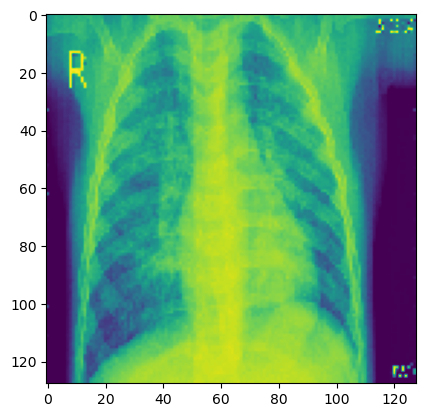

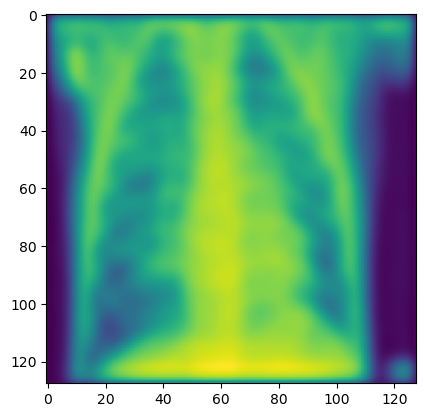

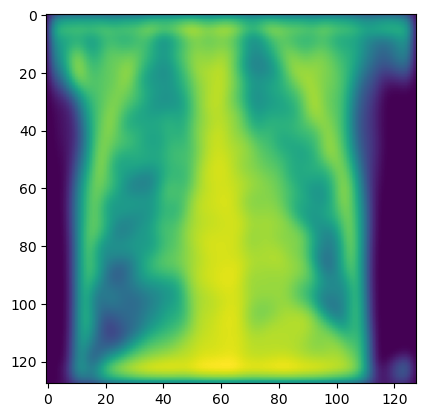

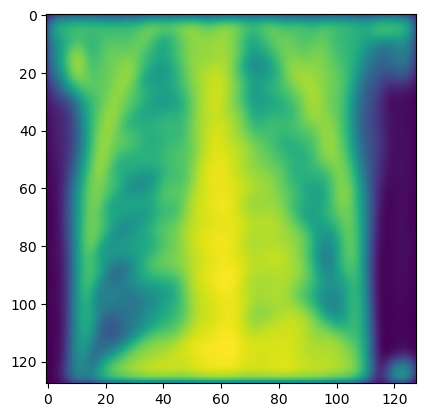

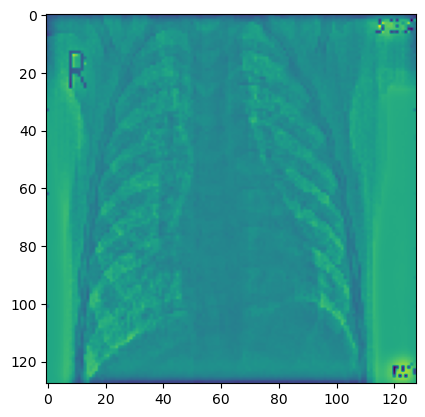

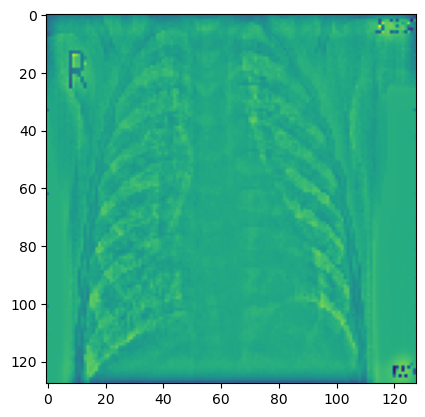

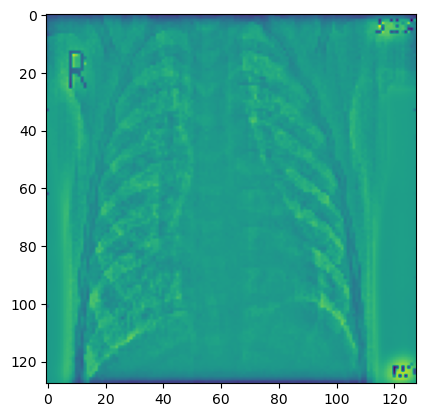

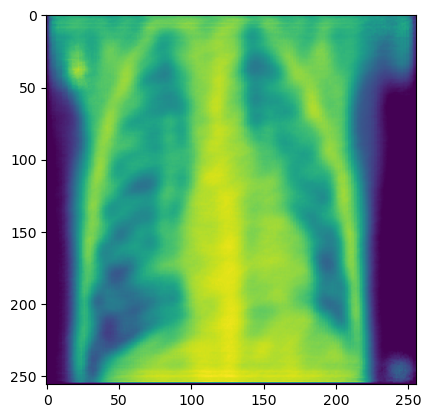

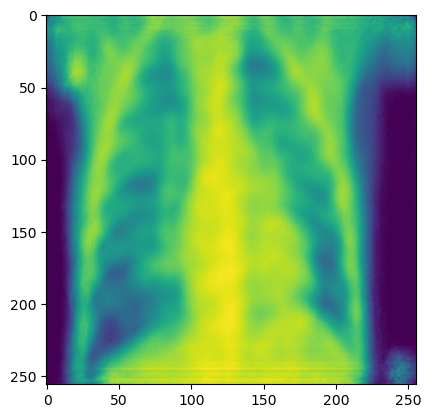

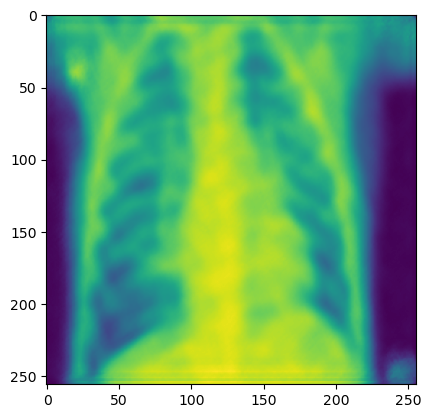

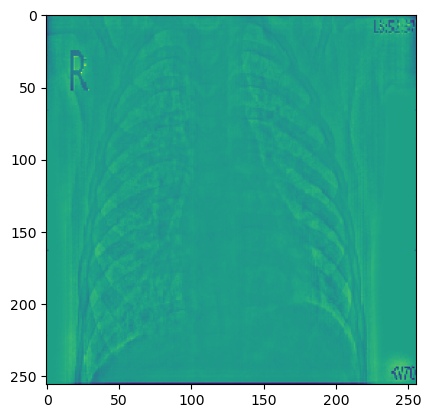

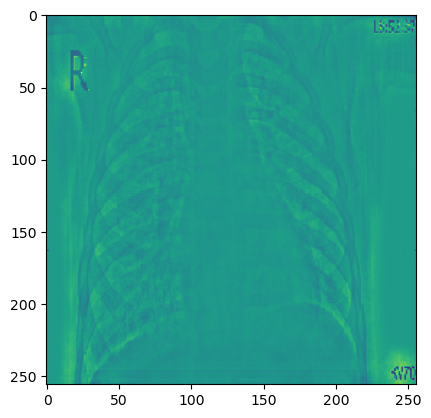

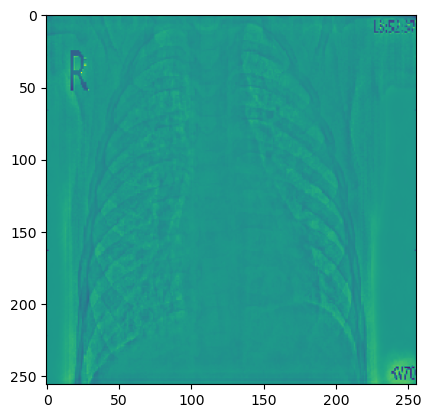

In [51]:
import matplotlib.pyplot as plt

x_128 = tensorflow.keras.utils.load_img(self.df["path"][i], target_size=(128,128), color_mode='grayscale') #chargement de l'image
            x_128 = tensorflow.keras.preprocessing.image.img_to_array(x_128) # transformation en array numpy
            x_128 =np.resize(x_128, (*self.output_size,1))

            x_256 = tensorflow.keras.utils.load_img(self.df["path"][i], target_size= (256,256), color_mode='grayscale') 
            x_256 = tensorflow.keras.preprocessing.image.img_to_array(x_256)
            x_256 =np.resize(x_256, (*self.input_size,1))

x_128 = tensorflow.keras.utils.load_img(train_all_df["path"][0], target_size=(128,128), color_mode='grayscale')
x_128 = tensorflow.keras.preprocessing.image.img_to_array(x_128) # transformation en array numpy
x_128 =np.resize(x_128, (*(128,128),1))
plt.imshow(x_128)
plt.show()

y_pred_norm_128 = train_all_df["outputs_256_to_128_norm"][0]
y_pred_pneumo_128 = train_all_df["outputs_256_to_128_pneumo"][0]
y_pred_covid_128 = train_all_df["outputs_256_to_128_covid"][0]

pn_128 =np.resize(y_pred_norm_128+1000, (*(128,128),1))
pp_128 =np.resize(y_pred_pneumo_128+1000, (*(128,128),1))
pc_128 =np.resize(y_pred_covid_128+1000, (*(128,128),1))

plt.imshow(pn_128)
plt.show()
plt.imshow(pp_128)
plt.show()
plt.imshow(pc_128)
plt.show()

y_erreur_norm_128 = train_all_df["erreur_256_to_128_norm"][0]
y_erreur_pneumo_128 = train_all_df["erreur_256_to_128_pneumo"][0]
y_erreur_covid_128 = train_all_df["erreur_256_to_128_covid"][0]
            
y_erreur_norm_128 =np.resize(y_erreur_norm_128, (*(128,128),1))
y_erreur_pneumo_128 =np.resize(y_erreur_pneumo_128, (*(128,128),1))
y_erreur_covid_128 =np.resize(y_erreur_covid_128, (*(128,128),1))

y_pred_norm_256 = train_all_df["outputs_128_to_256_norm"][0]
y_pred_pneumo_256 = train_all_df["outputs_128_to_256_pneumo"][0]
y_pred_covid_256 = train_all_df["outputs_128_to_256_covid"][0]

y_pred_norm_256 =np.resize(y_pred_norm_256+1000 , (*(256,256),1))
y_pred_pneumo_256 =np.resize(y_pred_pneumo_256+1000 , (*(256,256),1))
y_pred_covid_256 =np.resize(y_pred_covid_256+1000 , (*(256,256),1))

y_erreur_norm_256 = train_all_df["erreur_128_to_256_norm"][0]
y_erreur_pneumo_256 = train_all_df["erreur_128_to_256_pneumo"][0]
y_erreur_covid_256 = train_all_df["erreur_128_to_256_covid"][0]

y_erreur_norm_256 =np.resize(y_erreur_norm_256 , (*(256,256),1))
y_erreur_pneumo_256 =np.resize(y_erreur_pneumo_256 , (*(256,256),1))
y_erreur_covid_256 =np.resize(y_erreur_covid_256 , (*(256,256),1))

plt.imshow(y_erreur_norm_128)
plt.show()
plt.imshow(y_erreur_pneumo_128)
plt.show()
plt.imshow(y_erreur_covid_128)
plt.show()


plt.imshow(y_pred_norm_256)
plt.show()
plt.imshow(y_pred_pneumo_256)
plt.show()
plt.imshow(y_pred_covid_256)
plt.show()

plt.imshow(y_erreur_norm_256)
plt.show()
plt.imshow(y_erreur_pneumo_256)
plt.show()
plt.imshow(y_erreur_covid_256)
plt.show()


def augment_input(pn_128, pp_128, pc_128, en_128, ep_128, ec_128, pn_256, pp_256, pc_256,en_256, ep_256,ec_256):
    # Apply data augmentation to the input images x1 and x2
        image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,  # rotation jusqu'à 30° 
            zoom_range=0.1,     # zoom juqu'à 10%
            brightness_range=[0.8, 1.2], # luminosité impacté
            fill_mode='reflect', # mode de completion de l'image modifié
        )
        seed = np.random.randint(0, 10000) # generate a random seed
        pn_128 = image_generator.random_transform(pn_128, seed=seed)
        pp_128 = image_generator.random_transform(pp_128, seed=seed)
        pc_128 = image_generator.random_transform(pc_128, seed=seed)
        en_128 = image_generator.random_transform(en_128, seed=seed)
        ep_128 = image_generator.random_transform(ep_128, seed=seed)
        ec_128 = image_generator.random_transform(ec_128, seed=seed)
        pn_256 = image_generator.random_transform(pn_256, seed=seed)
        pp_256 = image_generator.random_transform(pp_256, seed=seed)
        pc_256 = image_generator.random_transform(pc_256, seed=seed)
        en_256 = image_generator.random_transform(en_256, seed=seed)
        ep_256 = image_generator.random_transform(ep_256, seed=seed)
        ec_256 = image_generator.random_transform(ec_256, seed=seed)
        return  pn_128, pp_128, pc_128, en_128, ep_128,ec_128, pn_256, pp_256, pc_256,en_256, ep_256,ec_256
    
pn_128, pp_128, pc_128, en_128, ep_128,ec_128, pn_256, pp_256, pc_256,en_256, ep_256,ec_256 = augment_input(pn_128, pp_128, pc_128,y_erreur_norm_128, y_erreur_pneumo_128, y_erreur_covid_128,y_pred_norm_256, y_pred_pneumo_256, y_pred_covid_256,y_erreur_norm_256, y_erreur_pneumo_256, y_erreur_covid_256)    
 

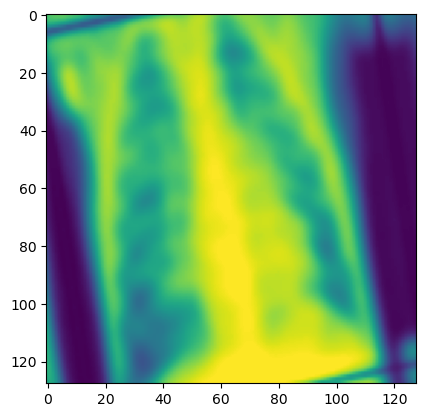

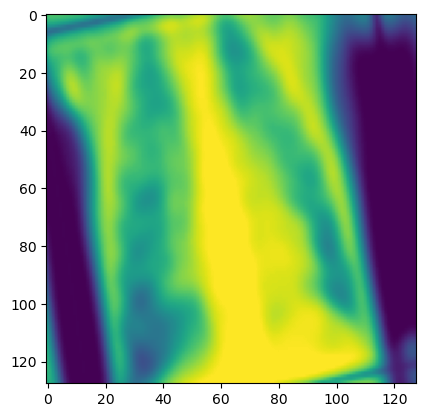

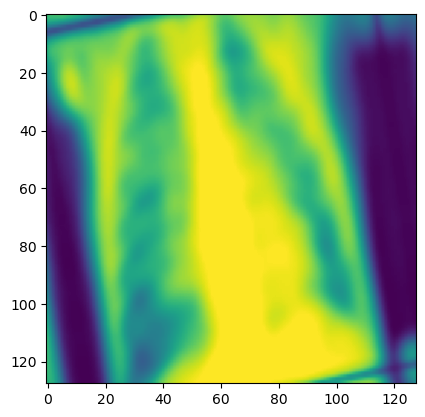

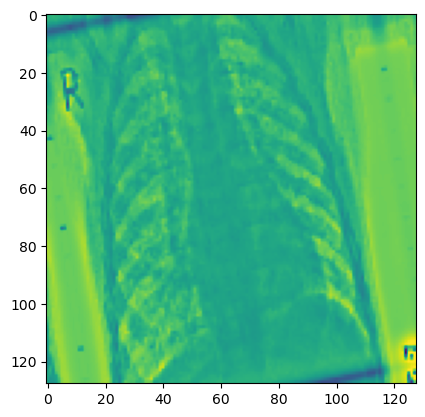

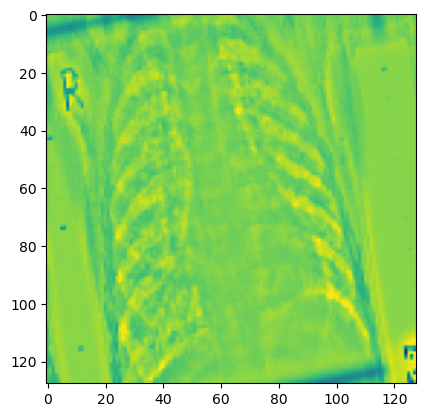

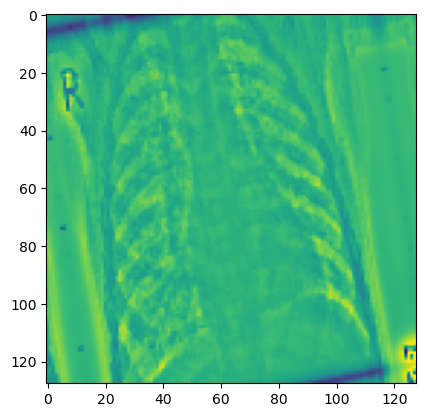

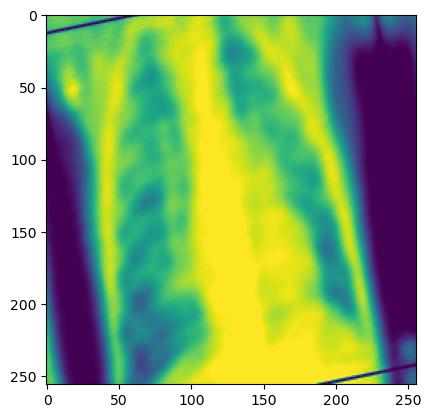

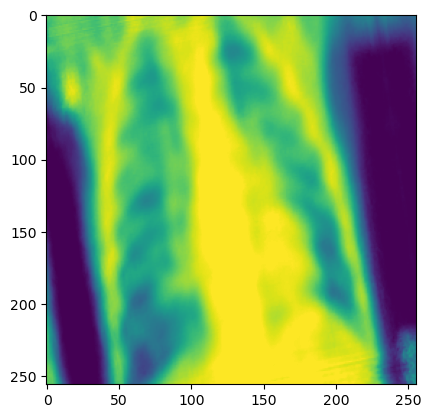

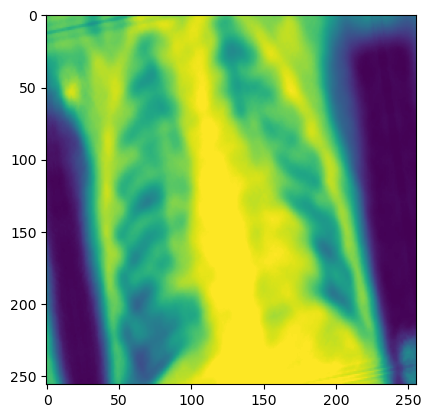

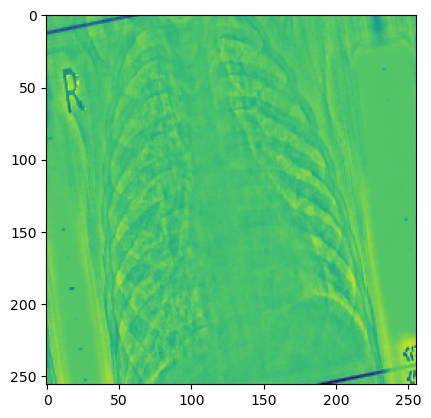

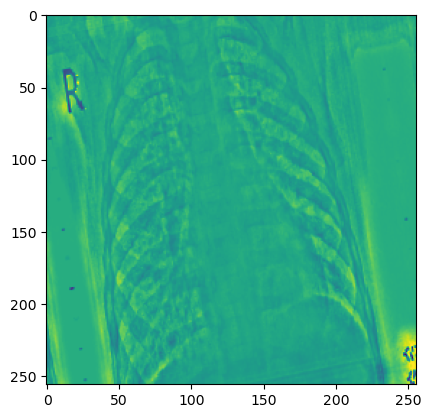

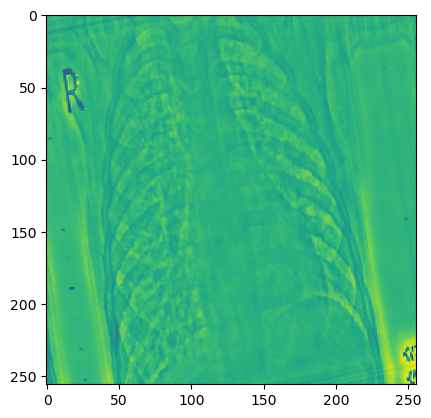

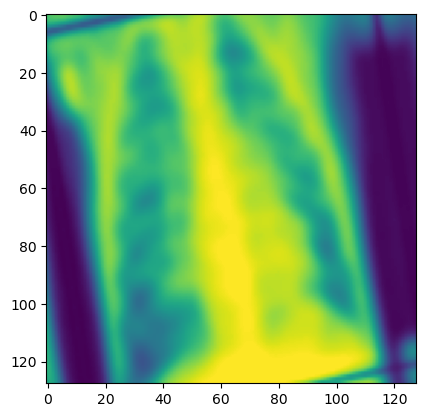

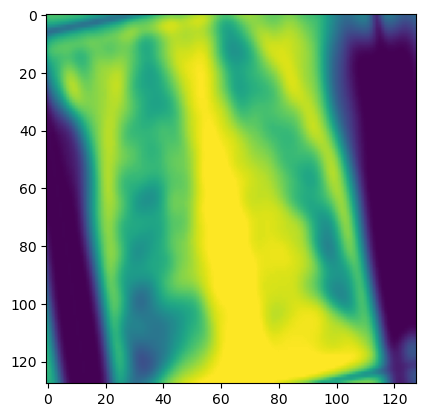

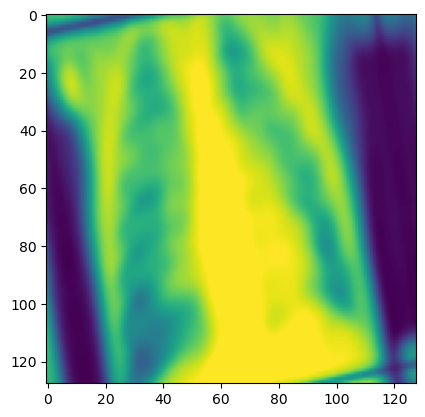

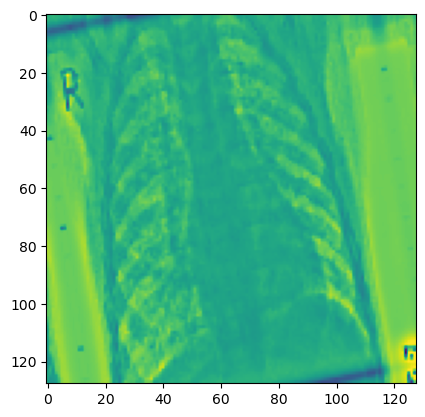

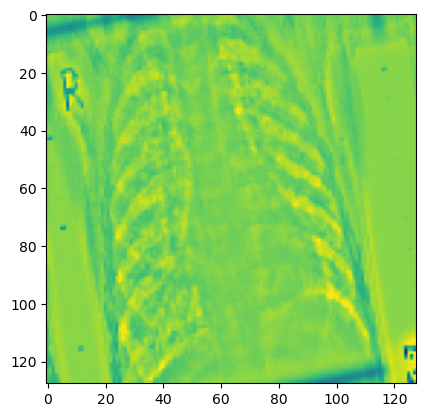

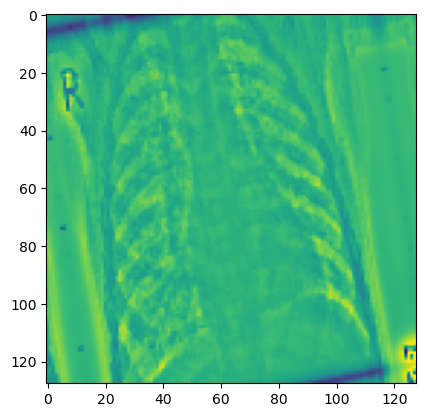

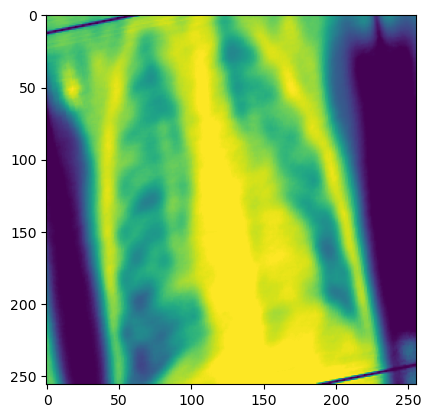

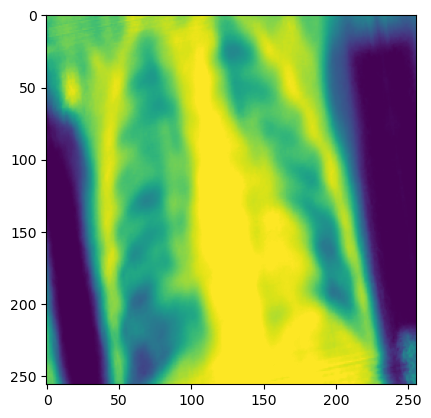

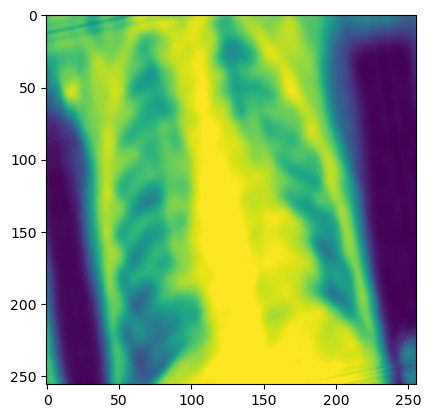

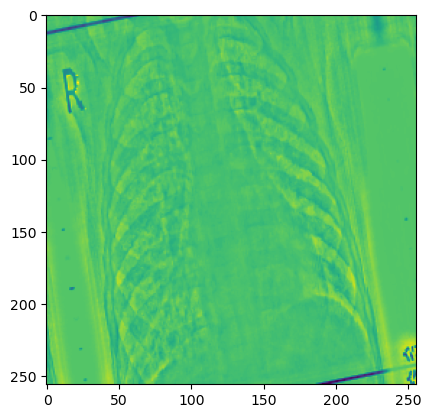

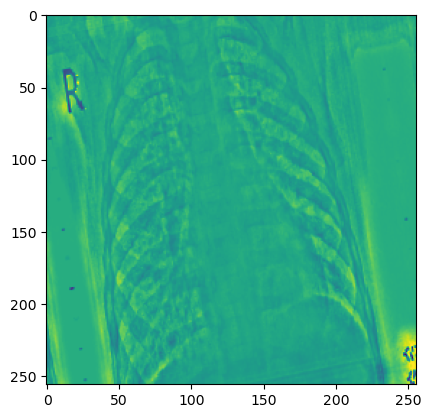

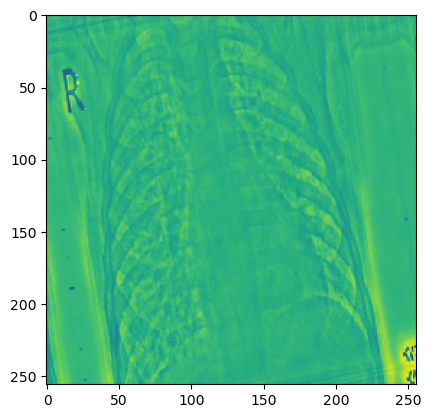

In [53]:
plt.imshow(pn_128)
plt.show()
plt.imshow(pp_128)
plt.show()
plt.imshow(pc_128)
plt.show()

plt.imshow(en_128)
plt.show()
plt.imshow(ep_128)
plt.show()
plt.imshow(ec_128)
plt.show()

plt.imshow(pn_256)
plt.show()
plt.imshow(pp_256)
plt.show()
plt.imshow(pc_256)
plt.show()

plt.imshow(en_256)
plt.show()
plt.imshow(ep_256)
plt.show()
plt.imshow(ec_256)
plt.show()

pn_128 = (pn_128- np.min(pn_128)) / (np.max(pn_128) - np.min(pn_128))
pn_128 = np.reshape(pn_128,(*(128,128),1)).astype('float32')
            
pp_128 = (pp_128- np.min(pp_128)) / (np.max(pp_128) - np.min(pp_128))
pp_128 = np.reshape(pp_128,(*(128,128),1)).astype('float32') 

pc_128 = (pc_128- np.min(pc_128)) / (np.max(pc_128) - np.min(pc_128))
pc_128 = np.reshape(pc_128,(*(128,128),1)).astype('float32') 

en_128 = (en_128- np.min(en_128)) / (np.max(en_128) - np.min(en_128))
en_128 = np.reshape(en_128,(*(128,128),1)).astype('float32') 

ep_128 = (ep_128- np.min(ep_128)) / (np.max(ep_128) - np.min(ep_128))
ep_128 = np.reshape(ep_128,(*(128,128),1)).astype('float32') 

ec_128 = (ec_128- np.min(ec_128)) / (np.max(ec_128) - np.min(ec_128))
ec_128 = np.reshape(ec_128,(*(128,128),1)).astype('float32')

pn_256 = (pn_256- np.min(pn_256)) / (np.max(pn_256) - np.min(pn_256))
pn_256 = np.reshape(pn_256,(*(256,256),1)).astype('float32') 

pp_256 = (pp_256- np.min(pp_256)) / (np.max(pp_256) - np.min(pp_256))
pp_256 = np.reshape(pp_256,(*(256,256),1)).astype('float32') 

pc_256 = (pc_256- np.min(pc_256)) / (np.max(pc_256) - np.min(pc_256))
pc_256 = np.reshape(pc_256,(*(256,256),1)).astype('float32') 

en_256 = (en_256- np.min(en_256)) / (np.max(en_256) - np.min(en_256))
en_256 = np.reshape(en_256,(*(256,256),1)).astype('float32') 

ep_256 = (ep_256- np.min(ep_256)) / (np.max(ep_256) - np.min(ep_256))
ep_256 = np.reshape(ep_256,(*(256,256),1)).astype('float32') 

ec_256 = (ec_256- np.min(ec_256)) / (np.max(ec_256) - np.min(ec_256))
ec_256 = np.reshape(ec_256,(*(256,256),1)).astype('float32')
plt.imshow(pn_128)
plt.show()
plt.imshow(pp_128)
plt.show()
plt.imshow(pc_128)
plt.show()

plt.imshow(en_128)
plt.show()
plt.imshow(ep_128)
plt.show()
plt.imshow(ec_128)
plt.show()

plt.imshow(pn_256)
plt.show()
plt.imshow(pp_256)
plt.show()
plt.imshow(pc_256)
plt.show()

plt.imshow(en_256)
plt.show()
plt.imshow(ep_256)
plt.show()
plt.imshow(ec_256)
plt.show()

In [161]:
train_all_df = train_all_df.reset_index(drop= True)
val_all_df = val_all_df.reset_index(drop= True)

train_all_generator=CustomDataGenerator_2_2_class_256_to_128(train_all_df, batch_size=32)
valid_all_generator=CustomDataGenerator_2_2_class_256_to_128_valid(val_all_df, batch_size=32)

In [154]:
from tensorflow.keras.layers import Concatenate

def my_conv_block_256(inputs):
    x = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(inputs)
    x = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x


def my_conv_block_128(inputs):
    x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(inputs)
    x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

def my_conv_block_2(inputs):
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(inputs)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

def my_conv_block_3(inputs):
    x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(inputs)
    x = Conv2D(filters=264, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = Conv2D(filters=264, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x= Flatten()(x)
    return x

# Define the inputs
predicted_input_norm_256 = Input(shape=(256, 256, 1))
predicted_input_pneumo_256 = Input(shape=(256, 256, 1))
predicted_input_covid_256 = Input(shape=(256, 256, 1))

error_input_norm_256 = Input(shape=(256, 256, 1))
error_input_pneumo_256 = Input(shape=(256, 256, 1))
error_input_covid_256 = Input(shape=(256, 256, 1))

predicted_input_norm_128 = Input(shape=(128, 128, 1))
predicted_input_pneumo_128 = Input(shape=(128, 128, 1))
predicted_input_covid_128 = Input(shape=(128, 128, 1))

error_input_norm_128 = Input(shape=(128, 128, 1))
error_input_pneumo_128 = Input(shape=(128, 128, 1))
error_input_covid_128 = Input(shape=(128, 128, 1))


# Define the model using the block of layers
flat_predicted_norm_256 = my_conv_block_256(predicted_input_norm_256)
flat_predicted_pneumo_256 = my_conv_block_256(predicted_input_pneumo_256)
flat_predicted_covid_256 = my_conv_block_256(predicted_input_covid_256)

flat_error_norm_256 = my_conv_block_256(error_input_norm_256)
flat_error_pneumo_256 = my_conv_block_256(error_input_pneumo_256)
flat_error_covid_256 = my_conv_block_256(error_input_covid_256)

flat_predicted_norm_128 = my_conv_block_128(predicted_input_norm_128)
flat_predicted_pneumo_128 = my_conv_block_128(predicted_input_pneumo_128)
flat_predicted_covid_128 = my_conv_block_128(predicted_input_covid_128)

flat_error_norm_128 = my_conv_block_128(error_input_norm_128)
flat_error_pneumo_128 = my_conv_block_128(error_input_pneumo_128)
flat_error_covid_128 = my_conv_block_128(error_input_covid_128)

concat_pred_norm = Concatenate(axis=3)([flat_predicted_norm_256, flat_predicted_norm_128])
concat_error_norm = Concatenate(axis=3)([flat_error_norm_256, flat_error_norm_128])

concat_pred_pneumo = Concatenate(axis=3)([flat_predicted_pneumo_256, flat_predicted_pneumo_128])
concat_error_pneumo = Concatenate(axis=3)([flat_error_pneumo_256, flat_error_pneumo_128])

concat_pred_covid = Concatenate(axis=3)([flat_predicted_covid_256, flat_predicted_covid_128])
concat_error_covid = Concatenate(axis=3)([flat_error_covid_256, flat_error_covid_128])


concat_pred_norm = my_conv_block_2(concat_pred_norm)
concat_error_norm = my_conv_block_2(concat_error_norm)

concat_pred_pneumo = my_conv_block_2(concat_pred_pneumo)
concat_error_pneumo = my_conv_block_2(concat_error_pneumo)

concat_pred_covid = my_conv_block_2(concat_pred_covid)
concat_error_covid = my_conv_block_2(concat_error_covid)

concat_pred_all = Concatenate(axis=3)([concat_pred_covid, concat_pred_pneumo,concat_pred_norm])
concat_pred_all = my_conv_block_3(concat_pred_all)

concat_error_all = Concatenate(axis=3)([concat_error_norm,concat_error_pneumo, concat_error_covid])
concat_error_all = my_conv_block_3(concat_error_all)

concat= Concatenate(axis=1)([concat_pred_all,concat_error_all])

dense_all = Dense(1024, activation= 'relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.1))(concat)
dense_all = Dense(512, activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.1))(dense_all)
dense_all = Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.1))(dense_all)
outputs = Dense(3, activation='softmax')(dense_all)

optimizer= Adam(learning_rate= 0.01, epsilon=0.1)
# create new model


model_auto = Model(inputs=[predicted_input_norm_128, predicted_input_pneumo_128,
                           predicted_input_covid_128, error_input_norm_128, error_input_pneumo_128,error_input_covid_128,predicted_input_norm_256, predicted_input_pneumo_256, predicted_input_covid_256,
                           error_input_norm_256,error_input_pneumo_256, error_input_covid_256], outputs=outputs)
model_auto.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_auto.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_279 (InputLayer)         [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_278 (InputLayer)         [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_277 (InputLayer)         [(None, 256, 256, 1  0           []                               
                                )]                                                         

In [162]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    if epoch < 3:
        return 0.01
    else:
        return 0.01

lr_scheduler = LearningRateScheduler(lr_schedule)
# Création d'un objet EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, restore_best_weights=True)

In [ ]:
history_model_auto = model_auto.fit(train_all_generator, epochs=15, validation_data=valid_all_generator, callbacks= ([lr_scheduler,early_stop]))

Epoch 1/15
74/74 [==============================] - 106s 1s/step - loss: 5.0954 - accuracy: 0.9761 - val_loss: 5.7092 - val_accuracy: 0.8089 - lr: 0.0100
Epoch 2/15
74/74 [==============================] - 105s 1s/step - loss: 4.9768 - accuracy: 0.9692 - val_loss: 5.2092 - val_accuracy: 0.7782 - lr: 0.0100
Epoch 3/15
74/74 [==============================] - 105s 1s/step - loss: 4.8259 - accuracy: 0.9675 - val_loss: 5.4141 - val_accuracy: 0.7782 - lr: 0.0100
Epoch 4/15
74/74 [==============================] - 105s 1s/step - loss: 4.7532 - accuracy: 0.9513 - val_loss: 4.8587 - val_accuracy: 0.8720 - lr: 0.0100
Epoch 5/15
74/74 [==============================] - 106s 1s/step - loss: 4.5616 - accuracy: 0.9675 - val_loss: 4.6161 - val_accuracy: 0.9676 - lr: 0.0100
Epoch 6/15
74/74 [==============================] - 105s 1s/step - loss: 4.4048 - accuracy: 0.9850 - val_loss: 4.4819 - val_accuracy: 0.9352 - lr: 0.0100
Epoch 7/15
74/74 [==============================] - 105s 1s/step - loss: 4.2

In [170]:
model_auto.save('classificateur_autoenc_final3.h5')

In [6]:
model_auto_1 = tensorflow.keras.models.load_model('classificateur_autoenc_all_first_any_percent.h5',compile=False)

In [171]:

classificateur_autoenc_final1= tensorflow.keras.models.load_model('classificateur_autoenc_final3.h5',compile=False)


y_pred_liste=[]
y_true_liste=[]
y_pred_argmax_liste=[]
df_all_test = df_all_test.reset_index(drop=True)

for i in range(len(df_all_test["path"])):
    y_pred_norm_128 = df_all_test["outputs_256_to_128_norm"][i]
    y_pred_pneumo_128 = df_all_test["outputs_256_to_128_pneumo"][i]
    y_pred_covid_128 = df_all_test["outputs_256_to_128_covid"][i]

    pn_128 =np.resize(y_pred_norm_128+1000, (*(128,128),1))
    pp_128 =np.resize(y_pred_pneumo_128+1000, (*(128,128),1))
    pc_128 =np.resize(y_pred_covid_128+1000, (*(128,128),1))

    y_erreur_norm_128 = df_all_test["erreur_256_to_128_norm"][i]
    y_erreur_pneumo_128 = df_all_test["erreur_256_to_128_pneumo"][i]
    y_erreur_covid_128 = df_all_test["erreur_256_to_128_covid"][i]

    en_128 =np.resize(y_erreur_norm_128, (*(128,128),1))
    ep_128 =np.resize(y_erreur_pneumo_128, (*(128,128),1))
    ec_128 =np.resize(y_erreur_covid_128, (*(128,128),1))

    y_pred_norm_256 = df_all_test["outputs_128_to_256_norm"][i]
    y_pred_pneumo_256 = df_all_test["outputs_128_to_256_pneumo"][i]
    y_pred_covid_256 = df_all_test["outputs_128_to_256_covid"][i]

    pn_256 =np.resize(y_pred_norm_256+1000 , (*(256,256),1))
    pp_256 =np.resize(y_pred_pneumo_256+1000 , (*(256,256),1))
    pc_256 =np.resize(y_pred_covid_256+1000 , (*(256,256),1))

    y_erreur_norm_256 = df_all_test["erreur_128_to_256_norm"][i]
    y_erreur_pneumo_256 = df_all_test["erreur_128_to_256_pneumo"][i]
    y_erreur_covid_256 = df_all_test["erreur_128_to_256_covid"][i]

    en_256 =np.resize(y_erreur_norm_256, (*(256,256),1))
    ep_256 =np.resize(y_erreur_pneumo_256 , (*(256,256),1))
    ec_256 =np.resize(y_erreur_covid_256 , (*(256,256),1))


    pn_128 = (pn_128- np.min(pn_128)) / (np.max(pn_128) - np.min(pn_128))
    pn_128 = np.reshape(pn_128,(*(128,128),1)).astype('float32')

    pp_128 = (pp_128- np.min(pp_128)) / (np.max(pp_128) - np.min(pp_128))
    pp_128 = np.reshape(pp_128,(*(128,128),1)).astype('float32') 

    pc_128 = (pc_128- np.min(pc_128)) / (np.max(pc_128) - np.min(pc_128))
    pc_128 = np.reshape(pc_128,(*(128,128),1)).astype('float32') 

    en_128 = (en_128- np.min(en_128)) / (np.max(en_128) - np.min(en_128))
    en_128 = np.reshape(en_128,(*(128,128),1)).astype('float32') 

    ep_128 = (ep_128- np.min(ep_128)) / (np.max(ep_128) - np.min(ep_128))
    ep_128 = np.reshape(ep_128,(*(128,128),1)).astype('float32') 

    ec_128 = (ec_128- np.min(ec_128)) / (np.max(ec_128) - np.min(ec_128))
    ec_128 = np.reshape(ec_128,(*(128,128),1)).astype('float32')

    pn_256 = (pn_256- np.min(pn_256)) / (np.max(pn_256) - np.min(pn_256))
    pn_256 = np.reshape(pn_256,(*(256,256),1)).astype('float32') 

    pp_256 = (pp_256- np.min(pp_256)) / (np.max(pp_256) - np.min(pp_256))
    pp_256 = np.reshape(pp_256,(*(256,256),1)).astype('float32') 

    pc_256 = (pc_256- np.min(pc_256)) / (np.max(pc_256) - np.min(pc_256))
    pc_256 = np.reshape(pc_256,(*(256,256),1)).astype('float32') 

    en_256 = (en_256- np.min(en_256)) / (np.max(en_256) - np.min(en_256))
    en_256 = np.reshape(en_256,(*(256,256),1)).astype('float32') 

    ep_256 = (ep_256- np.min(ep_256)) / (np.max(ep_256) - np.min(ep_256))
    ep_256 = np.reshape(ep_256,(*(256,256),1)).astype('float32') 

    ec_256 = (ec_256- np.min(ec_256)) / (np.max(ec_256) - np.min(ec_256))
    ec_256 = np.reshape(ec_256,(*(256,256),1)).astype('float32') 

    
    y= df_all_test["label"][i]
    y= np.resize(y, (1, 1))

    batch_pn_128 = np.resize(pn_128, (1, *(128,128),1))
    batch_pp_128 = np.resize(pp_128, (1, *(128,128),1))
    batch_pc_128 = np.resize(pc_128, (1, *(128,128),1))

    batch_en_128 = np.resize(en_128, (1, *(128,128),1))
    batch_ep_128 = np.resize(ep_128, (1, *(128,128),1))
    batch_ec_128 = np.resize(ec_128, (1, *(128,128),1))

    batch_pn_256 = np.resize(pn_256, (1, *(256,256),1))
    batch_pp_256 = np.resize(pp_256, (1, *(256,256),1))
    batch_pc_256 = np.resize(pc_256, (1, *(256,256),1))

    batch_en_256 = np.resize(en_256, (1, *(256,256),1))
    batch_ep_256 = np.resize(ep_256, (1, *(256,256),1))
    batch_ec_256 = np.resize(ec_256, (1, *(256,256),1))
 
    batch_y = y

    y_pred = classificateur_autoenc_final1.predict((batch_pn_128,batch_pp_128,batch_pc_128,batch_en_128,batch_ep_128,batch_ec_128,batch_pn_256,batch_pp_256,batch_pc_256,batch_en_256,batch_ep_256,batch_ec_256),verbose= 0)
    y_pred_argmax = np.argmax(y_pred, axis=1)
    y_pred_liste.extend(y_pred)
    y_pred_argmax_liste.extend(y_pred_argmax)
    y_true_liste.extend(y)

In [173]:

y_true_liste = np.reshape(y_true_liste, (732))
y_pred_argmax_liste = np.reshape(y_pred_argmax_liste, (732))
print(pd.crosstab(y_true_liste, y_pred_argmax_liste))

col_0    0    1    2
row_0               
0      226   29    5
1       42  195   10
2       35   14  176


In [ ]:
auto_norm_256_128 = tensorflow.keras.models.load_model('autoencoder_normal_256_to_128_07noise.h5',compile=False)
auto_pneumo_256_128  = tensorflow.keras.models.load_model('autoencoder_pneumo_256_to_128_07noise.h5',compile=False)
auto_covid_256_128  = tensorflow.keras.models.load_model('autoencoder_covid_256_to_128_07noise.h5',compile=False)

auto_norm_128_256 = tensorflow.keras.models.load_model('autoencoder_normal_128_to_256_07noise.h5',compile=False)
auto_pneumo_128_256  = tensorflow.keras.models.load_model('autoencoder_pneumo_128_to_256_07noise.h5',compile=False)
auto_covid_128_256 = tensorflow.keras.models.load_model('autoencoder_covid_128_to_256_07noise.h5',compile=False)

In [ ]:
model_auto_1 = tensorflow.keras.models.load_model('classificateur_autoenc_all_first_any_percent.h5',compile=False)

In [ ]:
df_test= pd.read_csv("data/test.csv")
df_test['path']=  df_test['image_id'].apply(lambda x: 'data/data/' + x)
df_test.head()


In [ ]:
y_pred_liste=[]
y_true_liste=[]
y_pred_argmax_liste=[]

for i in range(len(df_test["path"])):
    
        x = tensorflow.keras.utils.load_img(df_test["path"][i], target_size=(256,256), color_mode='grayscale') #chargement de l'image
        x = tensorflow.keras.preprocessing.image.img_to_array(x) # transformation en array numpy 

        true_outputs = tensorflow.keras.utils.load_img(df_test["path"][i], target_size= (128,128), color_mode='grayscale') 
        true_outputs = tensorflow.keras.preprocessing.image.img_to_array(true_outputs)

        x = x + tensorflow.random.normal(shape=tensorflow.shape(x), mean=0.0, stddev=10) # ajout du bruit avant injection dans l'autoencoder
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        x = np.reshape(x,(*(256,256),1)).astype('float32') 
        true_outputs = (true_outputs - np.min(true_outputs)) / (np.max(true_outputs) - np.min(true_outputs))
        true_outputs = np.reshape(true_outputs,(*(128,128),1)).astype('float32')
        
        x=np.resize(x, (1,256,256,1))
            
        predicted_outputs_norm = auto_norm_256_128.predict(x, verbose=0)
        predicted_outputs_covid= auto_covid_256_128.predict(x, verbose=0)
        predicted_outputs_pneumo= auto_pneumo_256_128.predict(x, verbose=0)
        
        residual_img_norm =( predicted_outputs_norm - true_outputs)
        residual_img_covid =( predicted_outputs_covid - true_outputs )
        residual_img_pneumo = (predicted_outputs_pneumo - true_outputs)
        
        predicted_outputs_norm_128= np.resize(predicted_outputs_norm, (128,128))
        predicted_outputs_covid_128= np.resize(predicted_outputs_covid, (128,128)) 
        predicted_outputs_pneumo_128 = np.resize(predicted_outputs_pneumo, (128,128))  
            
        residual_img_norm_128 =np.resize(residual_img_norm, (128,128))
        residual_img_covid_128 =np.resize(residual_img_covid, (128,128))
        residual_img_pneumo_128 =np.resize(residual_img_pneumo, (128,128))
            
        x = tensorflow.keras.utils.load_img(df_test["path"][i], target_size=(128,128), color_mode='grayscale') #chargement de l'image
        x = tensorflow.keras.preprocessing.image.img_to_array(x) # transformation en array numpy 

        true_outputs = tensorflow.keras.utils.load_img(df_test["path"][i], target_size= (256,256), color_mode='grayscale') 
        true_outputs = tensorflow.keras.preprocessing.image.img_to_array(true_outputs)

        x = x + tensorflow.random.normal(shape=tensorflow.shape(x), mean=0.0, stddev=10) # ajout du bruit avant injection dans l'autoencoder
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        x = np.reshape(x,(*(128,128),1)).astype('float32') 
        true_outputs = (true_outputs - np.min(true_outputs)) / (np.max(true_outputs) - np.min(true_outputs))
        true_outputs = np.reshape(true_outputs,(*(256,256),1)).astype('float32')
        
        x=np.resize(x, (1,128,128,1))
            
        predicted_outputs_norm = auto_norm_128_256.predict(x, verbose=0)
        predicted_outputs_covid= auto_covid_128_256.predict(x, verbose=0)
        predicted_outputs_pneumo= auto_pneumo_128_256.predict(x, verbose=0)
        
        residual_img_norm =( predicted_outputs_norm - true_outputs)
        residual_img_covid =( predicted_outputs_covid - true_outputs )
        residual_img_pneumo = (predicted_outputs_pneumo - true_outputs)
        
        predicted_outputs_norm_256= np.resize(predicted_outputs_norm, (256,256))
        predicted_outputs_covid_256= np.resize(predicted_outputs_covid, (256,256))   
        predicted_outputs_pneumo_256 = np.resize(predicted_outputs_pneumo, (256,256))
        
        residual_img_norm_256 =np.resize(residual_img_norm, (256,256))
        residual_img_covid_256 =np.resize(residual_img_covid, (256,256))
        residual_img_pneumo_256 =np.resize(residual_img_pneumo, (256,256))
        
        
        y_pred_norm_128 = predicted_outputs_norm_128
        y_pred_pneumo_128 = predicted_outputs_pneumo_128
        y_pred_covid_128 = predicted_outputs_covid_128

        pn_128 =np.resize(y_pred_norm_128+1000, (*(128,128),1))
        pp_128 =np.resize(y_pred_pneumo_128+1000, (*(128,128),1))
        pc_128 =np.resize(y_pred_covid_128+1000, (*(128,128),1))

        y_erreur_norm_128 = residual_img_norm_128
        y_erreur_pneumo_128 = residual_img_pneumo_128
        y_erreur_covid_128 = residual_img_covid_128

        en_128 =np.resize(y_erreur_norm_128, (*(128,128),1))
        ep_128 =np.resize(y_erreur_pneumo_128, (*(128,128),1))
        ec_128 =np.resize(y_erreur_covid_128, (*(128,128),1))

        y_pred_norm_256 = predicted_outputs_norm_256
        y_pred_pneumo_256 = predicted_outputs_pneumo_256
        y_pred_covid_256 = predicted_outputs_covid_256

        pn_256 =np.resize(y_pred_norm_256+1000 , (*(256,256),1))
        pp_256 =np.resize(y_pred_pneumo_256+1000 , (*(256,256),1))
        pc_256 =np.resize(y_pred_covid_256+1000 , (*(256,256),1))

        y_erreur_norm_256 = residual_img_norm_256
        y_erreur_pneumo_256 = residual_img_pneumo_256
        y_erreur_covid_256 = residual_img_covid_256

        en_256 =np.resize(y_erreur_norm_256, (*(256,256),1))
        ep_256 =np.resize(y_erreur_pneumo_256 , (*(256,256),1))
        ec_256 =np.resize(y_erreur_covid_256 , (*(256,256),1))


        pn_128 = (pn_128- np.min(pn_128)) / (np.max(pn_128) - np.min(pn_128))
        pn_128 = np.reshape(pn_128,(*(128,128),1)).astype('float32')

        pp_128 = (pp_128- np.min(pp_128)) / (np.max(pp_128) - np.min(pp_128))
        pp_128 = np.reshape(pp_128,(*(128,128),1)).astype('float32') 

        pc_128 = (pc_128- np.min(pc_128)) / (np.max(pc_128) - np.min(pc_128))
        pc_128 = np.reshape(pc_128,(*(128,128),1)).astype('float32') 

        en_128 = (en_128- np.min(en_128)) / (np.max(en_128) - np.min(en_128))
        en_128 = np.reshape(en_128,(*(128,128),1)).astype('float32') 

        ep_128 = (ep_128- np.min(ep_128)) / (np.max(ep_128) - np.min(ep_128))
        ep_128 = np.reshape(ep_128,(*(128,128),1)).astype('float32') 

        ec_128 = (ec_128- np.min(ec_128)) / (np.max(ec_128) - np.min(ec_128))
        ec_128 = np.reshape(ec_128,(*(128,128),1)).astype('float32')

        pn_256 = (pn_256- np.min(pn_256)) / (np.max(pn_256) - np.min(pn_256))
        pn_256 = np.reshape(pn_256,(*(256,256),1)).astype('float32') 

        pp_256 = (pp_256- np.min(pp_256)) / (np.max(pp_256) - np.min(pp_256))
        pp_256 = np.reshape(pp_256,(*(256,256),1)).astype('float32') 

        pc_256 = (pc_256- np.min(pc_256)) / (np.max(pc_256) - np.min(pc_256))
        pc_256 = np.reshape(pc_256,(*(256,256),1)).astype('float32') 

        en_256 = (en_256- np.min(en_256)) / (np.max(en_256) - np.min(en_256))
        en_256 = np.reshape(en_256,(*(256,256),1)).astype('float32') 

        ep_256 = (ep_256- np.min(ep_256)) / (np.max(ep_256) - np.min(ep_256))
        ep_256 = np.reshape(ep_256,(*(256,256),1)).astype('float32') 

        ec_256 = (ec_256- np.min(ec_256)) / (np.max(ec_256) - np.min(ec_256))
        ec_256 = np.reshape(ec_256,(*(256,256),1)).astype('float32') 


        y= df_all_test["label"][i]
        y= np.resize(y, (1, 1))

        batch_pn_128 = np.resize(pn_128, (1, *(128,128),1))
        batch_pp_128 = np.resize(pp_128, (1, *(128,128),1))
        batch_pc_128 = np.resize(pc_128, (1, *(128,128),1))

        batch_en_128 = np.resize(en_128, (1, *(128,128),1))
        batch_ep_128 = np.resize(ep_128, (1, *(128,128),1))
        batch_ec_128 = np.resize(ec_128, (1, *(128,128),1))

        batch_pn_256 = np.resize(pn_256, (1, *(256,256),1))
        batch_pp_256 = np.resize(pp_256, (1, *(256,256),1))
        batch_pc_256 = np.resize(pc_256, (1, *(256,256),1))

        batch_en_256 = np.resize(en_256, (1, *(256,256),1))
        batch_ep_256 = np.resize(ep_256, (1, *(256,256),1))
        batch_ec_256 = np.resize(ec_256, (1, *(256,256),1))

        batch_y = y

        y_pred = model_auto_1.predict((batch_pn_128,batch_pp_128,batch_pc_128,batch_en_128,batch_ep_128,batch_ec_128,batch_pn_256,batch_pp_256,batch_pc_256,batch_en_256,batch_ep_256,batch_ec_256),verbose= 0)
        y_pred_argmax = np.argmax(y_pred, axis=1)
        y_pred_liste.extend(y_pred)
        y_pred_argmax_liste.extend(y_pred_argmax)

In [ ]:
y_pred_argmax_liste = np.reshape(y_pred_argmax_liste, (1569))
df_test["label"]= y_pred_argmax_liste
df_test['label'] = df_test['label'].replace({0 : 'NORMAL', 1:'PNEUMONIA', 2 :'COVID'})
df_test.info()


In [ ]:
df_test.to_csv('submission_clasificateur_autoencodeur_1.csv', index=False, columns=['image_id','trustii_id','label'], encoding='UTF-8')